# Transfer Learning CNN Using Pre-trained VGG16 Model

This kernel is based on the following:

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html


VGG16 model is an ImageNet competition-winning model created by researchers at Oxford.

ImageNet public domain image database. It has 14 million URLs of images, labeled by cloudsouring, in 1,000 class categories.


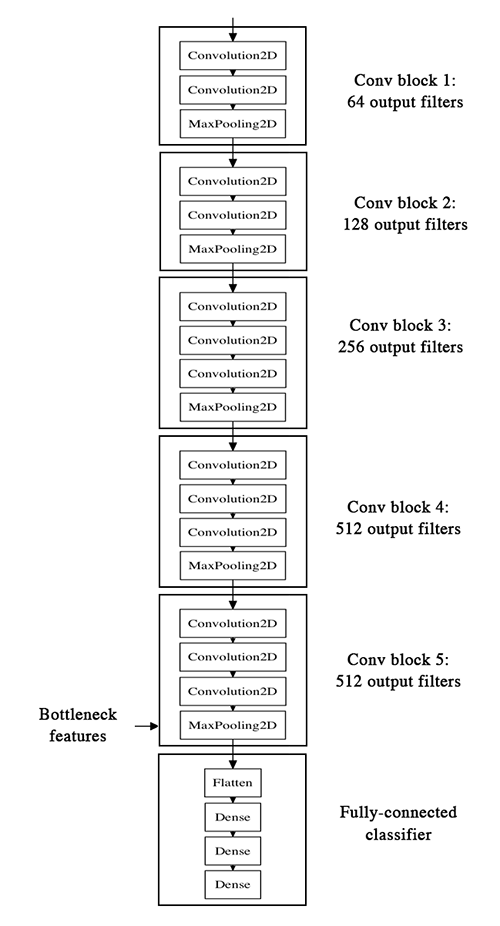

In [6]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

# dimensions of our images.
img_width, img_height = 150, 150

top_model_json_path = 'bottleneck_model_house.json'
top_model_weights_path = 'bottleneck_model_houses.h5'
train_data_dir = 'houses/train'
validation_data_dir = 'houses/validation'
nb_train_samples = 611
nb_validation_samples = 36
epochs = 1
batch_size = 16


In [7]:
def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    np.save('bottleneck_features_house_train', bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save('bottleneck_features_house_validation', bottleneck_features_validation)


In [8]:
def train_top_model():
    train_data = np.load('bottleneck_features_house_train.npy')
    train_labels = np.array([0] * 297 + [1] * 311)
    
    validation_data = np.load('bottleneck_features_house_validation.npy')
    validation_labels = np.array([0] * 15 + [1] * 17)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', #optimizer='rmsprop',
                  loss='binary_crossentropy',  metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels)
             )
    model.save_weights(top_model_weights_path)
    
    model_json = model.to_json()
    with open(top_model_json_path, "w") as json_file:
        json_file.write(model_json)
    
    return model

In [9]:
save_bottlebeck_features()

Found 611 images belonging to 2 classes.
Found 36 images belonging to 2 classes.


In [10]:
model = train_top_model()

Train on 608 samples, validate on 32 samples
Epoch 1/1
608/608 [==============================] - 2s 4ms/step - loss: 0.7012 - acc: 0.7155 - val_loss: 0.4398 - val_acc: 0.9062


In [11]:
from keras.models import model_from_json

json_file = open(top_model_json_path, 'r')
model_json = json_file.read()
json_file.close();
model = model_from_json(model_json)
model.load_weights(top_model_weights_path)

In [12]:
from keras.utils.vis_utils import plot_model
#plot_model(model)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________
None


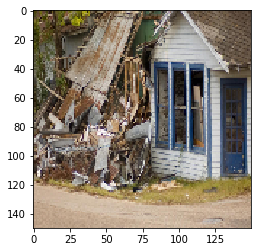

In [13]:
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt


# load an image from file
image = load_img('houses/test/1/10.jpg', target_size=(150, 150))
#image = load_img('houses/validation/2/sf2.jpg', target_size=(150, 150))
plt.imshow(image)

In [14]:
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input

model1 = applications.VGG16(include_top=False, weights='imagenet')

# convert the image pixels to a numpy array
image = img_to_array(image)

# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# prepare the image for the VGG model
image = preprocess_input(image)

vgg16Feat = model1.predict(image)

yhat = model.predict(vgg16Feat)
yhat_cls = model.predict_classes(vgg16Feat)

print("predicted=%s" % (yhat[0]))

yhat, yhat_cls

predicted=[4.405703e-09]


(array([[4.405703e-09]], dtype=float32), array([[0]]))

In [15]:
from keras.applications.vgg16 import VGG16

print(VGG16().summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [16]:

model = applications.VGG16(include_top=False, weights='imagenet')
    
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________